This notebook uses Azure Cognitive Services to transcribe text on an old map.
It then puts the text with its geographic location into a shapefile.
A blog post about it is here: http://jeffblackadar.ca/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac
# https://stackoverflow.com/questions/54613992/how-to-install-and-use-basemap-on-google-colab
# !apt-get install libgeos-3.6.2 (I am not sure if this is needed)
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install geopandas
!pip install contextily
!pip install -U rasterio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
     \ 129.7 MB 86 kB/s
ERROR: File "setup.py" not found for legacy project https://github.com/matplotlib/basemap/archive/master.zip.
     |████████████████████████████████| 1.0 MB 31.1 MB/s 
     |████████████████████████████████| 6.3 MB 42.1 MB/s 
     |████████████████████████████████| 16.7 MB 483 kB/s 
     |████████████████████████████████| 19.3 MB 234 kB/s 


In [3]:
!pip install --upgrade azure-cognitiveservices-vision-computervision

     |████████████████████████████████| 85 kB 3.6 MB/s 
     |████████████████████████████████| 41 kB 558 kB/s 


In [4]:
settings_path = "/content/drive/MyDrive/william_white/"
map_base_dir = '/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/'
    
import os
import json
# Set the file we wan!pip install --upgrade azure-cognitiveservices-vision-computervisiont to use for authenticating an Azure app
# The json file stores the COMPUTER_VISION_SUBSCRIPTION_KEY and COMPUTER_VISION_ENDPOINT so we don't have it in the code.
# The json file looks like this:
# {
# "COMPUTER_VISION_SUBSCRIPTION_KEY":"___the_COMPUTER_VISION_SUBSCRIPTION_KEY___",
# "COMPUTER_VISION_ENDPOINT":"___the_COMPUTER_VISION_ENDPOINT___"
# }
# cv.json contains the credentials for this program.
cv_settings_file = settings_path+'cv.json'
with open(cv_settings_file, "r") as read_file:
    cv_auth_data = json.load(read_file)

os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']=cv_auth_data["COMPUTER_VISION_SUBSCRIPTION_KEY"]
os.environ['COMPUTER_VISION_ENDPOINT']=cv_auth_data["COMPUTER_VISION_ENDPOINT"]

In [5]:
# https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/quickstarts-sdk/python-sdk
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials
from msrest.authentication import CognitiveServicesCredentials

from array import array
import os
from PIL import Image
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import pandas as pd
import contextily as ctx

In [6]:
# Add your Computer Vision subscription key to your environment variables.
if 'COMPUTER_VISION_SUBSCRIPTION_KEY' in os.environ:
    subscription_key = os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']
else:
    print("\nSet the COMPUTER_VISION_SUBSCRIPTION_KEY environment variable.\n**Restart your shell or IDE for changes to take effect.**")
    sys.exit()
# Add your Computer Vision endpoint to your environment variables.
if 'COMPUTER_VISION_ENDPOINT' in os.environ:
    endpoint = os.environ['COMPUTER_VISION_ENDPOINT']
else:
    print("\nSet the COMPUTER_VISION_ENDPOINT environment variable.\n**Restart your shell or IDE for changes to take effect.**")
    sys.exit()

In [12]:
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

# Set this up for a series of images

In [7]:
import math
def recognize_text_in_local_image(local_image_handwritten_path):
    local_image_handwritten = open(local_image_handwritten_path, "rb")
    # Call API with image and raw response (allows you to get the operation location)
    recognize_handwriting_results = computervision_client.read_in_stream(local_image_handwritten, raw=True, language='fr')

    # Get the operation location (URL with an ID at the end) from the response
    operation_location_remote = recognize_handwriting_results.headers["Operation-Location"]
    # Grab the ID from the URL
    operation_id = operation_location_remote.split("/")[-1]

    # Call the "GET" API and wait for it to retrieve the results 
    while True:
        get_handw_text_results = computervision_client.get_read_result(operation_id)
        if get_handw_text_results.status not in ['notStarted', 'running']:
            break
        time.sleep(1)

    # Print the detected text, line by line
    lines_of_text = []
    if get_handw_text_results.status == OperationStatusCodes.succeeded:
        for text_result in get_handw_text_results.analyze_result.read_results:
            for line in text_result.lines:
                line_data = []  
                #print(line.text)
                line_data.append(line.text)
                #print(line.bounding_box)
                line_data.append(line.bounding_box)
                pts = line_data[1]
                xd = abs(pts[4] - pts[0])
                yd = abs(pts[5] - pts[1])
                word_length = math.sqrt((xd ** 2) + (yd ** 2))
            
                letter_length = round(word_length/len(line.text))
                print(line.text +"  "+str(letter_length))
                line_data.append(letter_length)
                lines_of_text.append(line_data)
    return(lines_of_text)          


In [13]:
import cv2
import matplotlib.pyplot as plt
import gdal
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,500)
fontScale              = 1
fontColor              = (0,0,200)
fontColor_small        = (200,0,0)
lineType               = 2

def get_point_from_pixel(x,y, xoffset, px_w, rot1, yoffset, px_h, rot2):
    # supposing x and y are your pixel coordinate this 
    # is how to get the coordinate in space.
    posX = px_w * x + rot1 * y + xoffset
    posY = rot2 * x + px_h * y + yoffset

    posX = (px_w * x) + (rot1 * y) + xoffset
    posY = (px_h * y) + (rot2 * x) + yoffset
    # shift to the center of the pixel
    posX += px_w / 2.0
    posY += px_h / 2.0
    return(posX,posY)

def geocode_labels(local_image_handwritten_path, lines_of_text):
    img = cv2.imread(local_image_handwritten_path)
    img_ds = gdal.Open(local_image_handwritten_path)
    xoffset, px_w, rot1, yoffset, rot2, px_h  = img_ds.GetGeoTransform()

    line_text_poly = gpd.GeoDataFrame()
    line_text_poly['geometry'] = None
    #geotif_crs = 32128
    #geotif_crs = 32637 DAMAS
    geotif_crs = 32129 #PA South
    #geotif_crs = 4326
    line_text_poly.crs = ("EPSG:" + str(geotif_crs))
    line_text_poly.geometry = line_text_poly.geometry.to_crs(crs=geotif_crs)
    line_text_poly.to_crs(crs=geotif_crs)
    line_text_poly = line_text_poly.to_crs(epsg=geotif_crs)
   
    ln = 0
    for l in lines_of_text:
        pts = l[1]
        letter_size = l[2]
        fColor = fontColor
        if(letter_size < 90):
  
            p=[]
            for cn in range(0,4):
                p.append(get_point_from_pixel(pts[0+(cn*2)],pts[1+(cn*2)], xoffset, px_w, rot1, yoffset, px_h, rot2))
            coords = [(p[0][0], p[0][1]), (p[1][0], p[1][1]), (p[2][0], p[2][1]), (p[3][0], p[3][1])]
    
            poly = Polygon(coords)
            new_tp_row = {'id':ln, 'geometry':poly,'text':l[0]}
            line_text_poly = line_text_poly.append(new_tp_row, ignore_index=True)
    
    return(line_text_poly)

In [25]:
if True:
    if True:
        tiles = []

        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c00.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c01.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c02.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c03.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c04.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c05.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c06.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c07.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c00.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c01.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c02.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c03.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c04.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c05.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c06.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c07.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c00.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c01.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c02.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c03.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c04.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c05.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c06.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c07.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r03c00.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r03c01.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r03c02.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r03c03.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r03c04.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r03c05.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r03c06.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r03c07.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r04c00.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r04c01.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r04c02.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r04c03.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r04c04.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r04c05.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r04c06.tif')
        tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r04c07.tif')
        
        
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r05c00.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r05c01.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r05c02.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r05c03.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r05c04.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r05c05.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r05c06.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r05c07.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r06c00.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r06c01.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r06c02.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r06c03.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r06c04.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r06c05.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r06c06.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r06c07.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r07c00.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r07c01.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r07c02.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r07c03.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r07c04.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r07c05.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r07c06.tif')
        #tiles.append('/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r07c07.tif')


In [15]:
wkt102093 = '''PROJCRS["Roma_1940_Gauss_Boaga_Est",
    BASEGEOGCRS["GCS_Roma_1940",
        DATUM["D_Roma_1940",
            ELLIPSOID["International 1924",6378388,297,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["ESRI",104127]],
    CONVERSION["Italy zone 2",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",15,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",2520000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8807]]],
    CS[Cartesian,2],
        AXIS["(E)",east,
            ORDER[1],
            LENGTHUNIT["metre",1]],
        AXIS["(N)",north,
            ORDER[2],
            LENGTHUNIT["metre",1]],
    USAGE[
        SCOPE["unknown"],
        AREA["Italy - east of 12°E"],
        BBOX[34.76,12,47.1,18.99]],
    ID["ESRI",102093]]
Proj4
+proj=tmerc +lat_0=0 +lon_0=15 +k=0.9996 +x_0=2520000 +y_0=0 +ellps=intl +units=m +no_defs
Extent
12.00, 34.76, 18.99, 47.10'''


all_line_text_poly = gpd.GeoDataFrame()
all_line_text_poly['geometry'] = None
#geotif_crs = 4806
#geotif_crs = 4326
all_line_text_poly.crs = (wkt102093)
all_line_text_poly.geometry = all_line_text_poly.geometry.to_crs(wkt102093)
all_line_text_poly.to_crs(wkt102093)
all_line_text_poly = all_line_text_poly.to_crs(wkt102093)

for t in tiles:
    print(t)  
    lines_of_text = recognize_text_in_local_image(t)
    temp_df = geocode_labels(t,lines_of_text)
    all_line_text_poly = gpd.GeoDataFrame(pd.concat([all_line_text_poly,temp_df], ignore_index=True), crs=all_line_text_poly.crs)

all_line_text_poly.to_file(os.path.join(map_base_dir,"all_line_text.shp"))

/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c01.tif
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c02.tif
UST 11  49
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c03.tif
A44  44
PR  44
Z  66
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c00.tif
GA  34
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c01.tif
GABIL AREA URBANA  31
HW  24
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c02.tif
DD  32
AA  35
LL  30
ICC  19
AMB1.  24
Art6 2  21
NN  40
BB  37
USO AMB3  28
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c03.tif
ZŁ  26
999  27
UL  17
Z  65
RR  51
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r01c04.tif
/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r02c00.tif
/content/drive/MyDrive/gabii_legacy_gis_workin

PROJCS["Roma_1940_Gauss_Boaga_Est",GEOGCS["GCS_Roma_1940",DATUM["D_Roma_1940",SPHEROID["International 1924",6378388,297,AUTHORITY["EPSG","7022"]],AUTHORITY["ESRI","106275"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["ESRI","104127"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",2520000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102093"]]
PROJCRS["Roma_1940_Gauss_Boaga_Est",
    BASEGEOGCRS["GCS_Roma_1940",
        DATUM["D_Roma_1940",
            ELLIPSOID["International 1924",6378388,297,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["ESRI",104127]],
    CONVERSION["Italy zone 2",
        METHOD["Transverse Mercator",
    

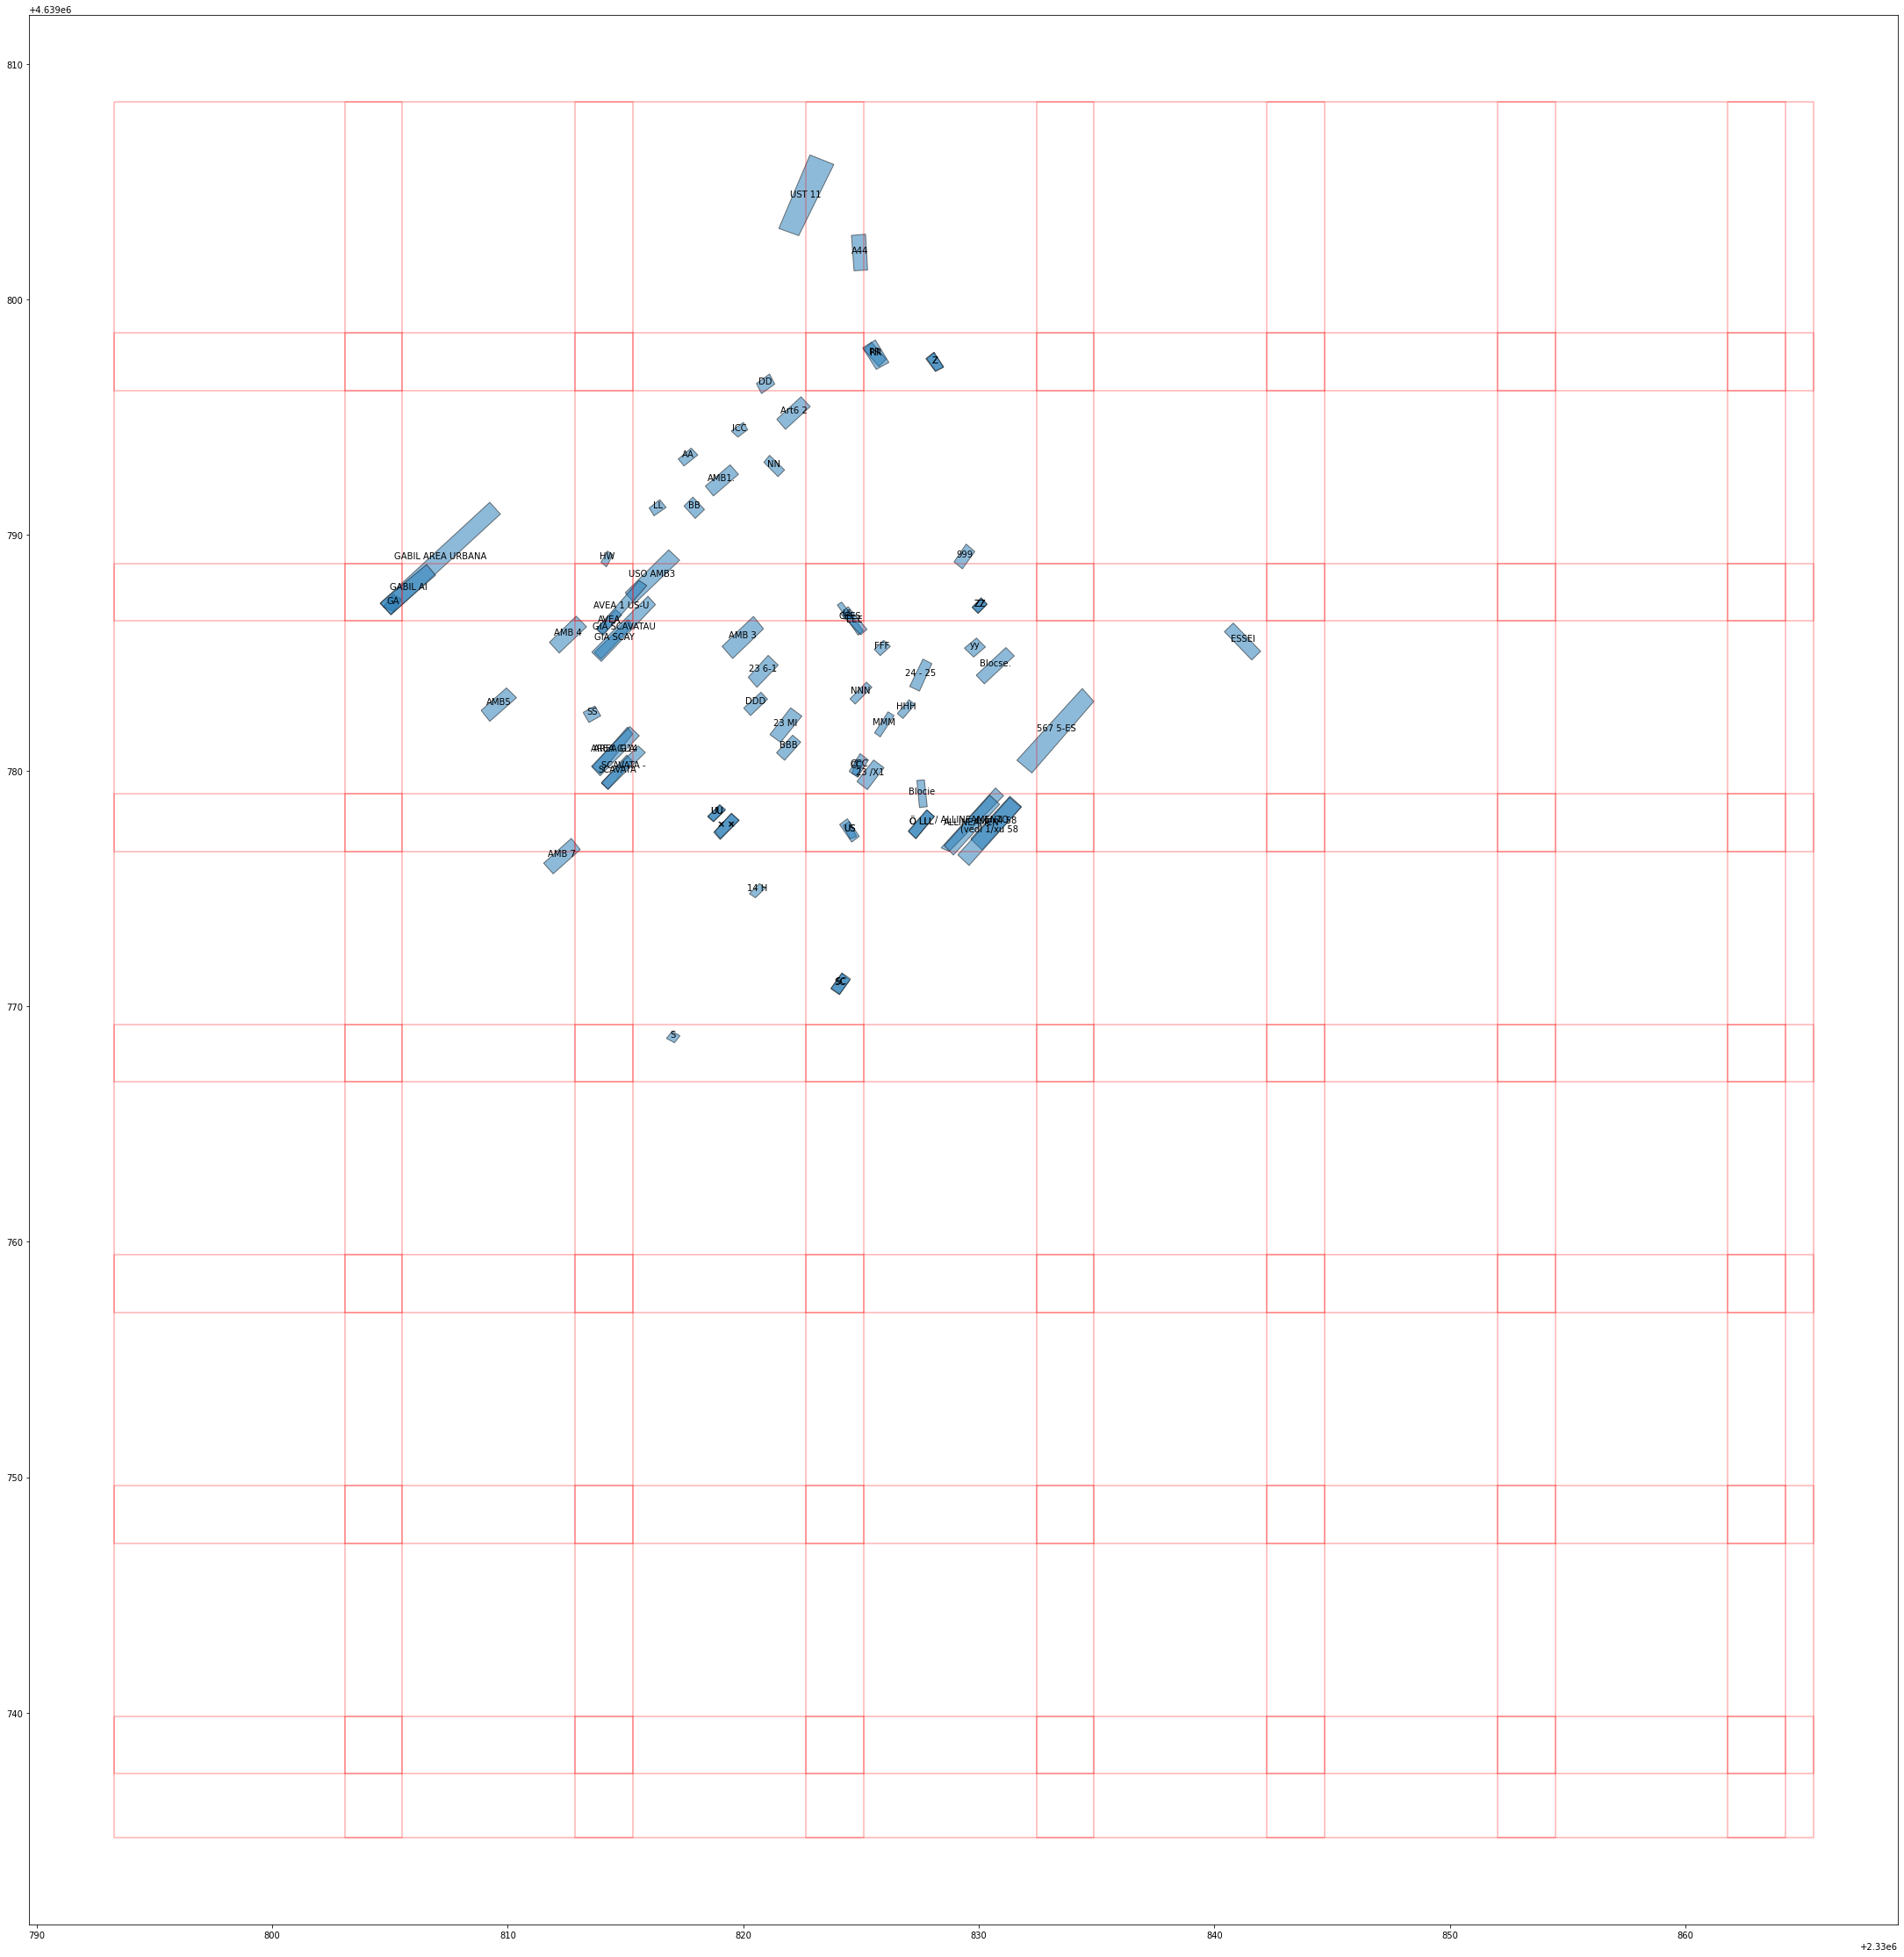

In [26]:
line_text_df=gpd.read_file(os.path.join(map_base_dir,"all_line_text.shp"))

print(line_text_df.crs)
# Change crs to one compatible with basemap
line_text_df = line_text_df.to_crs(wkt102093) 
print(line_text_df.crs)

ax = line_text_df.plot(figsize=(40, 40), alpha=0.5, edgecolor='k')
#ctx.add_basemap(ax)

tile_polys_df=gpd.read_file(os.path.join(map_base_dir,"tif_tiles/tile_polys.shp"))

#tile_polys_df = tile_polys_df.to_crs(epsg=3857) #3857
tile_polys_df.boundary.plot(ax=ax,color="red",alpha=0.3)

line_text_df['coords'] = line_text_df['geometry'].apply(lambda x: x.representative_point().coords[:])
line_text_df['coords'] = [coords[0] for coords in line_text_df['coords']]
for idx, row in line_text_df.iterrows():
    plt.annotate(s=row['text'], xy=row['coords'], horizontalalignment='center')

In [22]:
glist = line_text_df['geometry']
tlist = line_text_df['text']
rows_to_remove = []
print(len(glist))
for i in range(len(glist)):
    for j in range(i + 1, len(glist)):
        intersect_poly = glist[i].intersection(glist[j])

        if(not intersect_poly.is_empty):
            if(glist[i].area < glist[j].area):
                # glist[i] is smaller
                if(intersect_poly.area/glist[i].area >.8):
                    print("remove i : ", i, j, "{:3.2%}".format(intersect_poly.area/glist[i].area), int(intersect_poly.area), " Remove: ", tlist[i], int(glist[i].area), " Keep: ", tlist[j], int(glist[j].area))
                    rows_to_remove.append(i)
            else:
                if(glist[i].area >= glist[j].area):  
                  if(intersect_poly.area/glist[j].area >.8):
                        print("remove j : ", i, j, "{:3.2%}".format(intersect_poly.area/glist[j].area), int(intersect_poly.area), " Keep: ", tlist[i], int(glist[i].area),  " Remove: ", tlist[j], int(glist[j].area))
                        rows_to_remove.append(j)
                    #else:             
                    #    print("keep both: ", i, j, "{:3.2%}".format(intersect_poly.area/glist[i].area), "{:3.2%}".format(intersect_poly.area/glist[j].area), int(intersect_poly.area), tlist[i], int(glist[i].area), tlist[j], int(glist[j].area))


71
remove i :  2 20 100.00% 0  Remove:  PR 0  Keep:  RR 0
remove j :  3 19 98.79% 0  Keep:  Z 0  Remove:  Z 0
remove i :  4 5 100.00% 0  Remove:  GA 0  Keep:  GABIL AREA URBANA 4
remove i :  4 21 99.87% 0  Remove:  GA 0  Keep:  GABIL AI 1
remove j :  5 21 97.38% 1  Keep:  GABIL AREA URBANA 4  Remove:  GABIL AI 1
remove i :  16 48 97.27% 0  Remove:  Z? 0  Keep:  ZZ 0
remove i :  18 42 95.84% 0  Remove:  UL 0  Keep:  EEE 0
remove i :  24 28 98.48% 0  Remove:  AVEA 0  Keep:  AVEA 1 US-U 1
remove i :  25 29 100.00% 0  Remove:  GIA SCAY 0  Keep:  GIA SCAVATAU 1
remove i :  26 31 96.31% 0  Remove:  AREA GLA 0  Keep:  AREA G14 1
remove i :  27 32 91.65% 0  Remove:  SCAVATA 0  Keep:  SCAVATA - 0
remove i :  38 61 96.87% 0  Remove:  UU 0  Keep:  UU 0
remove j :  39 62 99.22% 0  Keep:  × × 0  Remove:  × × 0
remove i :  41 45 99.61% 0  Remove:  CC. 0  Keep:  CCC 0
remove i :  53 66 99.99% 0  Remove:  US 0  Keep:  US 0
remove i :  55 67 97.51% 0  Remove:  Ö LLL 0  Keep:  Ö LLL 0
remove i :  58 70 

In [23]:
print(rows_to_remove)
# remove the rows
line_text_df_deduplicated = line_text_df
line_text_df_deduplicated = line_text_df_deduplicated.drop(rows_to_remove)
print(len(line_text_df_deduplicated['geometry']))
print(line_text_df_deduplicated['coords'],type(line_text_df_deduplicated['coords']))
print(line_text_df_deduplicated)
print(line_text_df_deduplicated.columns)

print(type(line_text_df_deduplicated))
#we have to drop this since .shp files don't support tuples
line_text_df_deduplicated = line_text_df_deduplicated.drop(columns='coords')
line_text_df_deduplicated.to_file(os.path.join(map_base_dir,"all_line_text_deduplicated.shp"))

print(line_text_df_deduplicated.columns)

[2, 19, 4, 4, 21, 16, 18, 24, 25, 26, 27, 38, 62, 41, 53, 55, 58, 65]
54
0      (2330822.6290609324, 4639804.376524568)
1      (2330824.9407066936, 4639801.990339862)
3       (2330828.134381521, 4639797.315865209)
5       (2330807.129495555, 4639788.994810851)
6      (2330814.2121795733, 4639789.007047696)
7       (2330820.9453576617, 4639796.42257555)
8      (2330817.6502652196, 4639793.314417011)
9       (2330816.361604443, 4639791.160732354)
10       (2330819.839335165, 4639794.44632514)
11     (2330819.0917468937, 4639792.329351017)
12      (2330822.130758795, 4639795.186654242)
13      (2330821.309191445, 4639792.928956404)
14     (2330817.9158848803, 4639791.160732353)
15     (2330816.1332086516, 4639788.242244907)
17     (2330829.384458096, 4639789.0804687645)
20     (2330825.6297112145, 4639797.640141592)
22     (2330809.6193582267, 4639782.827441152)
23       (2330812.553369947, 4639785.77652071)
28      (2330814.8317265743, 4639786.93290253)
29     (2330814.9443741334, 463978

PROJCS["Roma_1940_Gauss_Boaga_Est",GEOGCS["GCS_Roma_1940",DATUM["D_Roma_1940",SPHEROID["International 1924",6378388,297,AUTHORITY["EPSG","7022"]],AUTHORITY["ESRI","106275"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["ESRI","104127"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",2520000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102093"]]
<open DatasetReader name='/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r04c07.tif' mode='r'>
<open DatasetReader name='/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c01.tif' mode='r'>
<open DatasetReader name='/content/drive/MyDrive/gabii_legacy_gis_working/terrible1998_map/tif_tiles/r00c02.tif' mode='r'>
<open Datas

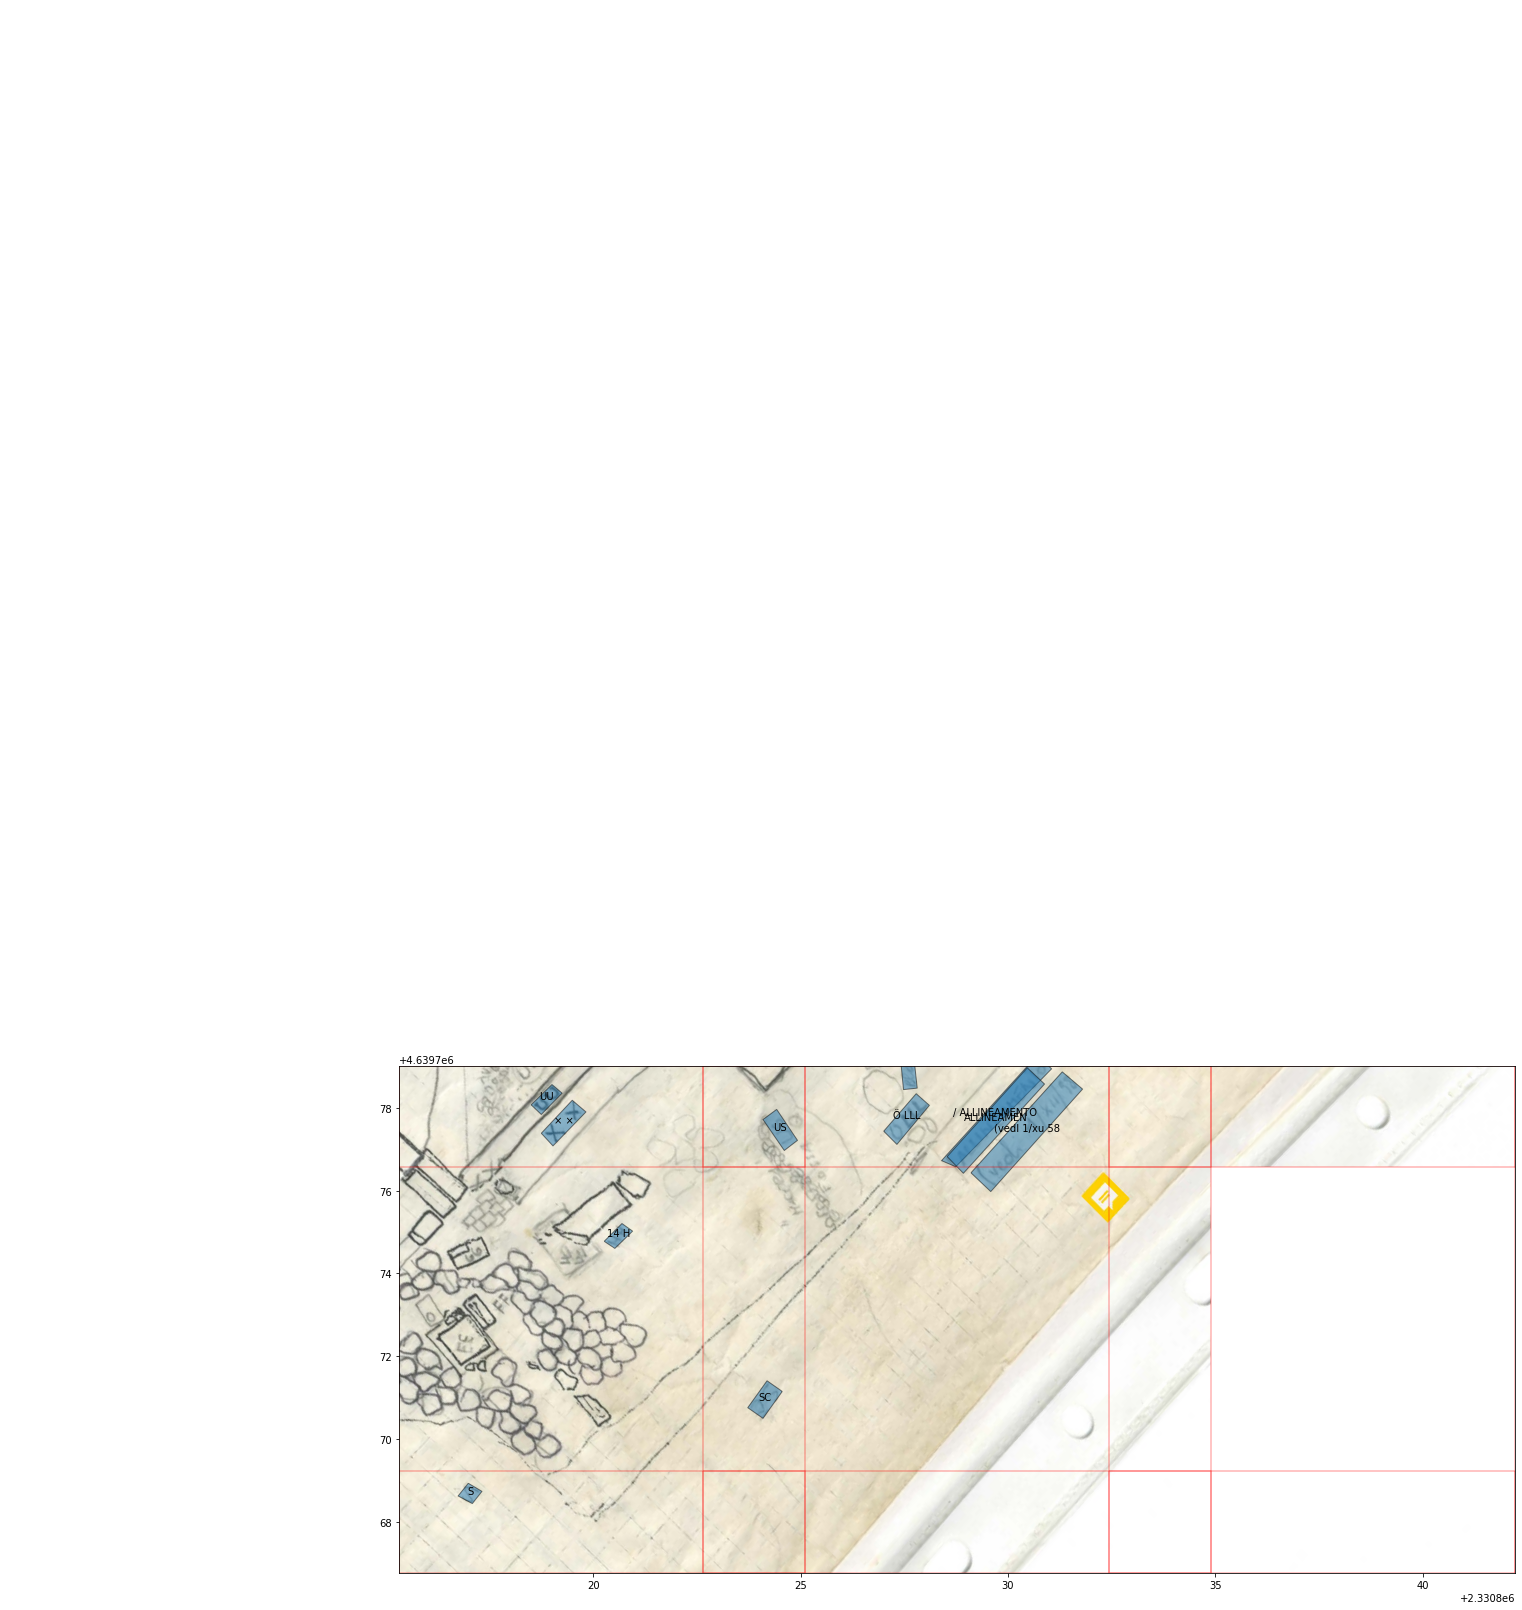

In [28]:
import rasterio
import rasterio.plot
line_text_df=gpd.read_file(os.path.join(map_base_dir,"all_line_text_deduplicated.shp"))
print(line_text_df.crs)
# Change crs to one compatible with basemap
#line_text_df = line_text_df.to_crs(epsg=3857) #3857
#line_text_df = line_text_df.to_crs(epsg=32127) #3857


ax = line_text_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')

for tf in tiles:
    print(tif_file)  
    tif_file = rasterio.open(tf)
    rasterio.plot.show(tif_file, ax=ax)
#ctx.add_basemap(ax)

tile_polys_df=gpd.read_file(os.path.join(map_base_dir,"tif_tiles/tile_polys.shp"))
#tile_polys_df = tile_polys_df.to_crs(epsg=3857) #3857
#tile_polys_df = tile_polys_df.to_crs(epsg=32637) #3857
tile_polys_df.boundary.plot(ax=ax,color="red",alpha=0.3)

line_text_df['coords'] = line_text_df['geometry'].apply(lambda x: x.representative_point().coords[:])
line_text_df['coords'] = [coords[0] for coords in line_text_df['coords']]
for idx, row in line_text_df.iterrows():
    plt.annotate(s=row['text'], xy=row['coords'],                 horizontalalignment='center')

In [ ]:
line_text_df=gpd.read_file(os.path.join(map_base_dir,"all_line_text_deduplicated.shp"))
print(line_text_df.crs)
# Change crs to one compatible with basemap
#line_text_df = line_text_df.to_crs(epsg=3857) #3857
#line_text_df = line_text_df.to_crs(epsg=4326) #3857
ax = line_text_df.plot(figsize=(40, 40), alpha=0.5, edgecolor='k')
for tf in tiles:
    tif_file = rasterio.open(tf)
    rasterio.plot.show(tif_file, ax=ax)

line_text_df.boundary.plot(ax=ax,color="red",alpha=0.5)


In [ ]:
#Remove all of the labels that have only numbers
import rasterio
import rasterio.plot

line_text_dedup_df=gpd.read_file(os.path.join(map_base_dir,"all_line_text_deduplicated.shp"))
print(line_text_dedup_df.crs)

glist_dedup = line_text_dedup_df['geometry']
tlist_dedup = line_text_dedup_df['text']
rows_dedup_to_remove = []
print(len(glist_dedup))
for i in range(len(glist_dedup)):
    print(" i : ", i, tlist_dedup[i])
    if(tlist_dedup[i].isnumeric()):
        rows_dedup_to_remove.append(i)
        print("remove i : ", i, tlist_dedup[i])
    if(len(tlist_dedup[i])==1):
        rows_dedup_to_remove.append(i)
        print("remove i : ", i, tlist_dedup[i])

print(rows_dedup_to_remove)
# remove the rows
line_text_df_no_nums = line_text_dedup_df
line_text_df_no_nums = line_text_dedup_df.drop(rows_dedup_to_remove)
print(len(line_text_df_no_nums['geometry']))

#print(line_text_df_no_nums['coords'],type(line_text_df_no_nums['coords']))
print(line_text_df_no_nums)
print(line_text_df_no_nums.columns)

print(type(line_text_df_no_nums))

line_text_df_no_nums.to_file(os.path.join(map_base_dir,"all_line_text_no_nums.shp"))

print(line_text_df_deduplicated.columns)


line_text_dedup_df=gpd.read_file(os.path.join(map_base_dir,"all_line_text_no_nums.shp"))
print(line_text_dedup_df.crs)

glist_dedup = line_text_dedup_df['geometry']
tlist_dedup = line_text_dedup_df['text']
print(len(glist_dedup))
for i in range(len(glist_dedup)):
    print(i, tlist_dedup[i])

In [ ]:
line_text_dedup_df=gpd.read_file(os.path.join(map_base_dir,"all_line_text_no_nums.shp"))
print(line_text_dedup_df.crs)

glist_dedup = line_text_dedup_df['geometry']
tlist_dedup = line_text_dedup_df['text']
print(len(glist_dedup))
for i in range(len(glist_dedup)):
    print(i, tlist_dedup[i])

In [ ]:
import geopandas
line_text_df_search_file = os.path.join(map_base_dir,"all_line_text_search.shp")
shp_file = geopandas.read_file(line_text_df_search_file)
shp_file.to_file(os.path.join(map_base_dir,"all_line_text_search.geojson"), driver='GeoJSON')

Download /content/line_text.shp to use it in other maps such as ArcGIS Map. 